# The Issue Description

Attached CSV is a file with some machine-generated user data of a food delivery service. Every row of the dataset represents one customer who has registered to use the service during September 2019 and either has or hasn’t made orders during the time from then and October 2020.

The assignment is to provide a user segmentation that could be utilised by marketing team to reactivate different kinds of users.

In [1]:
import pandas as pd
import numpy as np
import typing as tp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams

import datetime as dt

import warnings

from sklearn.mixture import GaussianMixture

In [2]:
df = pd.read_csv("dataset_for_clusterization.csv")
df.dtypes

REGISTRATION_DATE                           object
REGISTRATION_COUNTRY                        object
PURCHASE_COUNT                               int64
PURCHASE_COUNT_DELIVERY                    float64
PURCHASE_COUNT_TAKEAWAY                    float64
FIRST_PURCHASE_DAY                          object
LAST_PURCHASE_DAY                           object
USER_ID                                      int64
BREAKFAST_PURCHASES                        float64
LUNCH_PURCHASES                            float64
EVENING_PURCHASES                          float64
DINNER_PURCHASES                           float64
LATE_NIGHT_PURCHASES                       float64
TOTAL_PURCHASES_EUR                        float64
DISTINCT_PURCHASE_VENUE_COUNT              float64
MIN_PURCHASE_VALUE_EUR                     float64
MAX_PURCHASE_VALUE_EUR                     float64
AVG_PURCHASE_VALUE_EUR                     float64
PREFERRED_DEVICE                            object
IOS_PURCHASES                  

In [3]:
print(
    "sample size: " + str(df.shape[0])
    + "\n"
    + "unique user_id: " + str(len(np.unique(np.array(df.USER_ID))))
    + "\n"
    + "number of columns: " + str(len(df.columns))
)

sample size: 21983
unique user_id: 21983
number of columns: 30


My general idea is the following: if we want to divide users by some categorical data, we don't need any difficult evaluations. For example, such attribute as country of user should not be a part of some modelling, we are able to distinguish customers from different countries.

Another case when we have somehow distributed variables, for example, the amount of purchases and want to set three different samples with low, medium and high number of orders. What is low? 1, 10, or 100? In this case, we need some clusterization solutions.

In this dataset, we have both types of variables, and here I'm going to describe them, separate the original and synthetic metrics for clustering, and provide results and conclusions.

# Data Exploring

I'm going to clarify the logic of categorical and numeric variables and then provide some logic for their grouping and further use.

In [4]:
def hist(df_input: tp.Any) -> tp.Any:
    """Vizualisation of variable's distribution"""

    col = df_input.columns[0]
    df_input = df_input.rename(columns = {col:"value"})

    """
    I'm going to cut off the tail of distribution.

    I will use z-score or standard score - basically it's the number of standard deviations, 
    by which the value is above or below the mean value of what is being measured. 
    Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores.

    The standard score is calculating by following approach: z = (x - Xavg) / S, 
    where x is a variable value, Xavg - an average value for full sample 
    (arithmetical mean: Xavg = sum(x) / N, where N is the observation number), S - a standart deviasion of full sample).

    S is the square root of standart variance, S = sqrt ( sum ((x - Xavg)^2) / N )
    """    
    #Xavg
    avg = df_input.mean().value 
    
    #(x - Xavg)^2
    df_input["sq"] = (df_input.value - avg) ** 2
    
    #N
    count = df_input.count().sq 
    
    #sum ((x - Xavg)^2)
    sq_sum = df_input.sum().sq
    
    #S
    S = ( sq_sum / (count) ) ** (1/2)
    
    #z-score
    df_input["z"] = (df_input.value - avg) / S
    
    v_mean = df_input.mean().value
    v_median = df_input.median().value
    v_count = df_input.count().value
    
    #cutting off the tail
    df_z = df_input.query("z > 1.96").reset_index()
    
    tail_count = df_z.count().value
    tail_limit = df_z.min().value
    
    #use it in further visualization
    df_viz = df_input.query("z <= 1.96").reset_index()
    
    #define the bins number and provide warnings in case of some problems
    if np.isnan(tail_limit) == False:
        bins_num = int(tail_limit) - 1
        
        #make charts readable again
        if bins_num < 20:
            bins_num = bins_num
        else:
            bins_num = 20    
    
        rcParams['figure.figsize'] = 12,4
    
        system_hist = sns.histplot(
            df_viz
            , x = df_viz.value
            , palette = "light:m_r"
            , edgecolor = ".3"
            , linewidth = 1
            , bins = int(tail_limit) - 1
        )

        for p in system_hist.patches:
            system_hist.annotate(
                format(p.get_height(), '.0f')
                , (p.get_x() + p.get_width() / 2., p.get_height())
                , ha = 'center'
                , va = 'center'
                , xytext = (0, 10)
                , textcoords = 'offset points'
                , color = 'black'
                , fontweight ="bold"
                , size = 9
            )

        plt.axvline(
            v_mean
            , color = 'red'
            , label = 'mean'
            , linestyle = '--'
        )
        plt.text(
            x = v_mean + 0.3
            , y = max([h.get_height() for h in system_hist.patches])
            , s = 'mean: {:.0f}'.format(v_mean)
            , color = 'red'
        )

        plt.axvline(
            v_median
            , color = 'orange'
            , label = 'median'
            , linestyle = '--'
        )
        plt.text(
            x = v_median + 0.3
            , y = max([h.get_height() for h in system_hist.patches])
            , s = 'median: {:.0f}'.format(v_median)
            , color = 'orange'
        )

        plt.axvline(
            tail_limit
            , color = 'black'
            , label = '5% tail'
            , linestyle = '--'
        )
        plt.text(
            x = tail_limit + 0.3
            , y = max([h.get_height() for h in system_hist.patches])
            , s = '97,5% tail: {:.0f}'.format(tail_limit)
            , color = 'black'
        )
        system_hist.set_title(col + " distribution of " + str(count) + " users", fontweight ="bold", size = 16)

    #exclusions    
    else:
        print("No distribution of " + col)

    
    return print(
        "Sample size: " + str(v_count)
        + "\n"
        + "Mean value: " + str(round(v_mean, 2)) 
        + "\n"
        + "Median value: " + str(round(v_median, 2))
        + "\n"
        + "5%-tail limit: " + str(round(tail_limit, 2))
        + "\n"
        + "Tail size: " + str(tail_count)
    )

Sample size: 21983
Mean value: 3.35
Median value: 1.0
5%-tail limit: 21.0
Tail size: 751


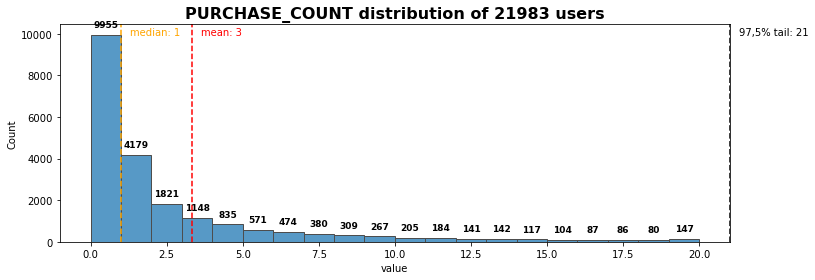

In [5]:
df_purchase = df[["PURCHASE_COUNT"]]

hist(df_purchase)

Sample size: 12028
Mean value: 6.11
Median value: 3.0
5%-tail limit: 28.0
Tail size: 447


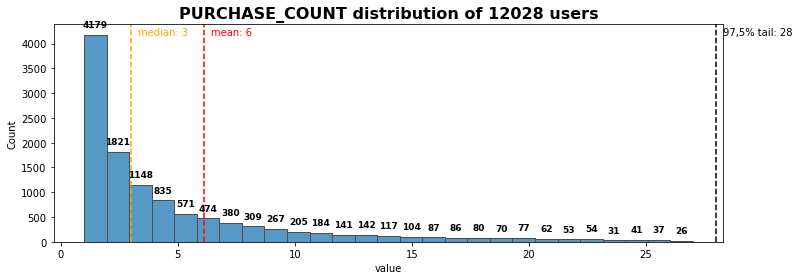

In [6]:
df_purchase = df_purchase.query("PURCHASE_COUNT > 0")
hist(df_purchase)

Almost half of users haven't ordered anything and that should be an attribute for segmentation. 

Well, here we have 30 columns, let's explore it. 

# Data Preparation 

Now I'm going to group the data and provide several conclusions regarding its further use.

I'm going to divide it into several groups:

- Group of Preferences: what types of restaurants and meals are interesting to users?
- Group of Behavior: what is the frequency of orders and how much money customers are going to spend?
- System attributes: how exactly the communication should be sent to customers. It should not be a part of analytical segmentation.

## 1. Group of System Attributes

- REGISTRATION_COUNTRY
- REGISTRATION_DATE                           
- PREFERRED_DEVICE
- IOS_PURCHASES
- WEB_PURCHASES
- ANDROID_PURCHASES
- USER_HAS_VALID_PAYMENT_METHOD
- AVERAGE_DELIVERY_DISTANCE_KMS

Such attributes as prefered devices and so on should be useful for designing the communication but not for analytical segmentation, because we have already had the data related to financial metrics and the history of orders. 

### 1.1 PREFERRED_DEVICE,  IOS_PURCHASES, WEB_PURCHASES, ANDROID_PURCHASES

In [7]:
def cat_hist(df_input: tp.Any) -> tp.Any:
    """
    Simple visuzalization for categorial data
    """
    
    df_gb = df_input.groupby(df_input.columns[0]).count()["USER_ID"].reset_index()
            
    rcParams['figure.figsize'] = 16,4
    
    cat_bar = sns.barplot(
        data = df_gb
        , y = df_gb.columns[0]
        , x = "USER_ID"
        , ci = None
        , palette = ["#87bdef"]
        , orient = "h"
    )
    
    cat_bar.set_title(df_input.columns[0] + " distribution", fontweight ="bold", size = 16)

    return print("sample size: " + str(df_input.shape[0]))

sample size: 21983


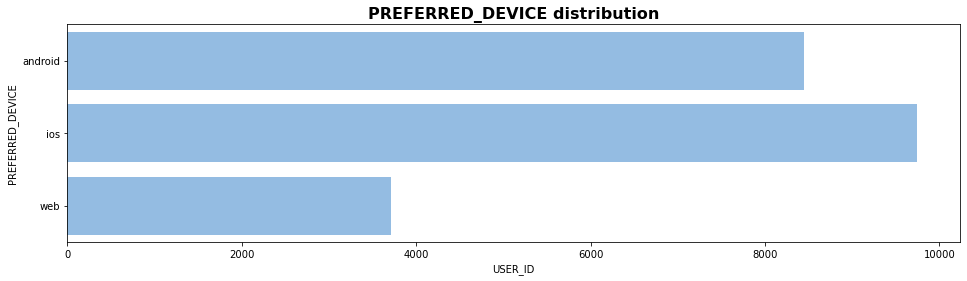

In [8]:
df_devices = df[["PREFERRED_DEVICE", "USER_ID"]]
cat_hist(df_devices)

Let's see if the logic of a preferred device correlates with purchases: consider that the maximum number of orders identifies the preferred type of device. Also, let's check if the number of orders per device is equal to PURCHASE_COUNT.

In [9]:
warnings.filterwarnings("ignore")

df_devices = df[["PREFERRED_DEVICE", "IOS_PURCHASES", "WEB_PURCHASES", "ANDROID_PURCHASES", "PURCHASE_COUNT", "USER_ID"]]

df_devices["all_devices"] = df_devices["IOS_PURCHASES"] + df_devices["WEB_PURCHASES"] + df_devices["ANDROID_PURCHASES"]
df_devices.query("PURCHASE_COUNT > 0 and all_devices != PURCHASE_COUNT")

,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PURCHASE_COUNT,USER_ID,all_devices


The amount is correct, let's check the correlation between maximum purchases and PREFFERED_DEVICE value.

In [10]:
df_devices["IOS_PURCHASES"] = df_devices["IOS_PURCHASES"].fillna(0)
df_devices["WEB_PURCHASES"] = df_devices["WEB_PURCHASES"].fillna(0)
df_devices["ANDROID_PURCHASES"] = df_devices["ANDROID_PURCHASES"].fillna(0)

df_devices["device"] = ""
for i in range(df_devices.shape[0]):    
    if df_devices.at[i, "IOS_PURCHASES"] > df_devices.at[i, "WEB_PURCHASES"] and df_devices.at[i, "IOS_PURCHASES"] > df_devices.at[i, "ANDROID_PURCHASES"]:
        df_devices.at[i, "device"] = "ios"
    elif df_devices.at[i, "ANDROID_PURCHASES"] > df_devices.at[i, "WEB_PURCHASES"] and df_devices.at[i, "ANDROID_PURCHASES"] > df_devices.at[i, "IOS_PURCHASES"]:
        df_devices.at[i, "device"] = "android"
    elif df_devices.at[i, "WEB_PURCHASES"] > df_devices.at[i, "IOS_PURCHASES"] and df_devices.at[i, "WEB_PURCHASES"] > df_devices.at[i, "ANDROID_PURCHASES"]:
          df_devices.at[i, "device"] = "web"
    else:
        df_devices.at[i, "device"] = "none"
        
df_devices.head()

,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,PURCHASE_COUNT,USER_ID,all_devices,device
0,ios,0.0,0.0,0.0,0,1,NaN,none
1,android,0.0,0.0,1.0,1,2,1.0,android
2,android,0.0,19.0,0.0,19,3,19.0,web
3,android,0.0,0.0,0.0,0,4,NaN,none
4,android,0.0,0.0,0.0,0,5,NaN,none


In [11]:
df_devices = df_devices.query("device != 'none' and device != PREFERRED_DEVICE")
df_devices.shape[0]

1180

We can notice that for 1 thousand of customers preferences don't correlate with their real purchase pattern. So, in case of mismatch I'm going to use it instead of PREFFERED_DEVICE.

### 1.2 REGISTRATION_COUNTRY 

In [12]:
df_country = df[["REGISTRATION_COUNTRY", "USER_ID"]]
df_country = df_country.groupby("REGISTRATION_COUNTRY").count()["USER_ID"].reset_index().sort_values(
    by = "USER_ID", ascending = False)
df_country.head()

,REGISTRATION_COUNTRY,USER_ID
17,FIN,10277
14,DNK,8081
23,GRC,3042
58,USA,70
20,GBR,54


sample size: 21983


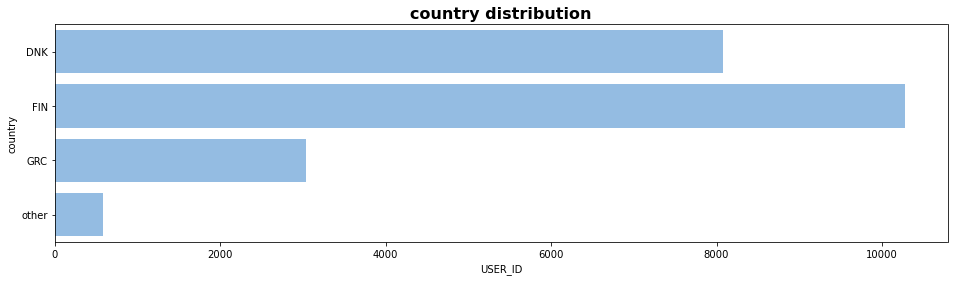

In [13]:
df_country = df[["REGISTRATION_COUNTRY", "USER_ID"]]

df_country["country"] = ""

for i in range(df_country.shape[0]):
    if df_country.at[i, "REGISTRATION_COUNTRY"] not in ("FIN", "DNK", "GRC"):
        df_country.at[i, "country"] = "other"
    else:
        df_country.at[i, "country"] =  df_country.at[i, "REGISTRATION_COUNTRY"] 
        
df_country = df_country[["country", "USER_ID"]]
cat_hist(df_country)

Almost all customers are from Denmark, Finland and Greece. Let's use these countries as the base for further segmentation, and users from other countries should be included in the same common segment.

### 1.3 REGISTRATION_DATE 

sample size: 21983


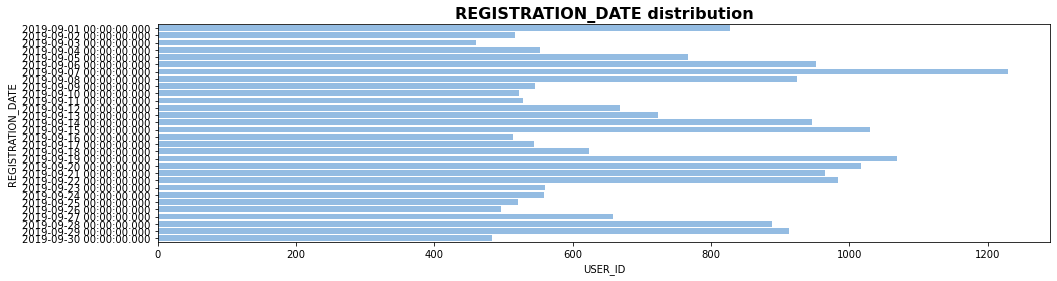

In [14]:
df_devices = df[["REGISTRATION_DATE", "USER_ID"]]
cat_hist(df_devices)

All customers in this sample have been registrated during September 2019. So I'm not going to use it somehow in segmentation: due to the last order have been created in October 2020, I consider all customers as the same segment.

### 1.4 AVERAGE_DELIVERY_DISTANCE_KMS 

sample size: 12028


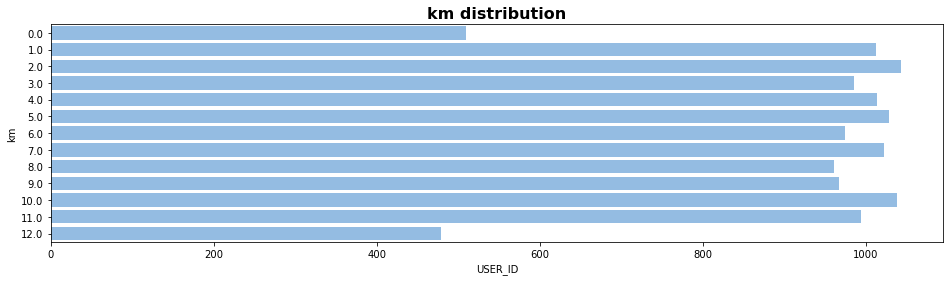

In [15]:
df_km = df[["USER_ID", "PURCHASE_COUNT", "AVERAGE_DELIVERY_DISTANCE_KMS"]]
df_km = df_km.query('PURCHASE_COUNT > 0')
df_km["km"] = round(df_km["AVERAGE_DELIVERY_DISTANCE_KMS"])
df_km = df_km[["km", "USER_ID"]]
cat_hist(df_km)

Actually I don't have any idea how to use this data. We can notice that customers are distributed almost by the same amounts per each rounded distance.

As we are going to reactivate samples, their locations could be changed, so I suggest some of this data should be outdated.

### 1.5 USER_HAS_VALID_PAYMENT_METHOD

sample size: 21983


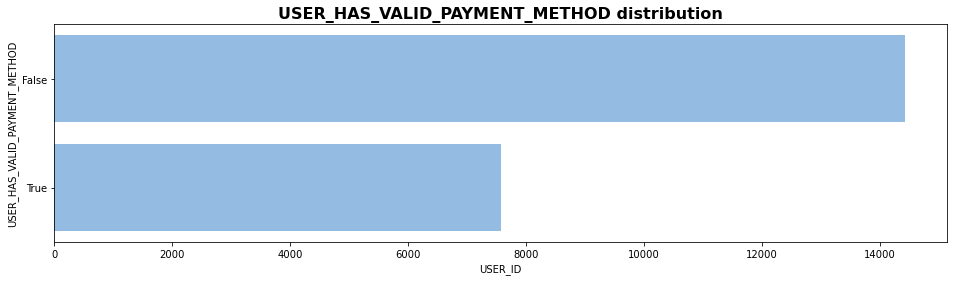

In [16]:
df_devices = df[["USER_HAS_VALID_PAYMENT_METHOD", "USER_ID"]]
cat_hist(df_devices)

The same conclusion as in previous point. Consider that we need to describe additionally how the order could be paid for those customers who didn't provide the valid method previously.

Here and below green color of boxes means using of attributes as is, yellow one – using with some changes, gray color – not using at all.

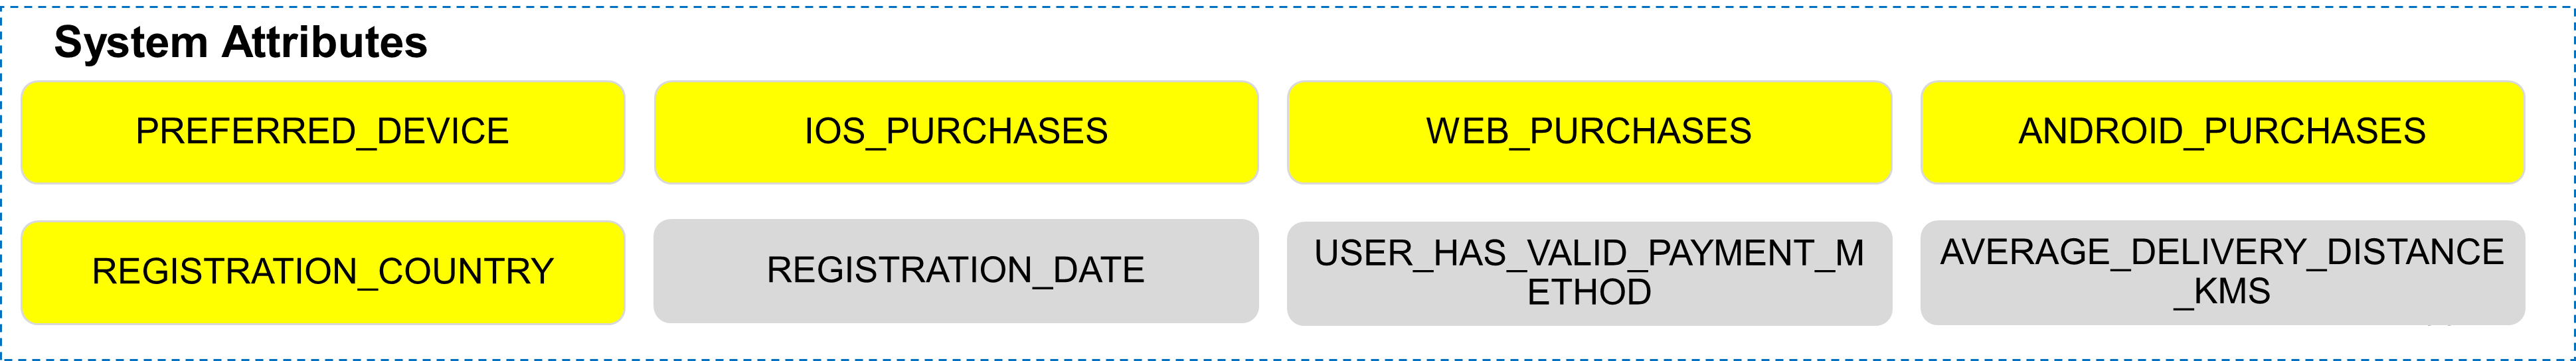

## 2. Group of Preferences 

These attributes describe what type of orders customers preffer to make.

- BREAKFAST_PURCHASES
- LUNCH_PURCHASES
- EVENING_PURCHASES
- DINNER_PURCHASES
- LATE_NIGHT_PURCHASES
- PREFERRED_RESTAURANT_TYPES
- MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE
- MOST_COMMON_WEEKDAY_TO_PURCHASE
- PURCHASE_COUNT_BY_STORE_TYPE
- PURCHASE_COUNT_TAKEAWAY
- PURCHASE_COUNT_DELIVERY
- DISTINCT_PURCHASE_VENUE_COUNT

### 2.1 PURCHASE_COUNT_DELIVERY and  PURCHASE_COUNT_TAKEAWAY

Is the amount of PURCHASE_COUNT_DELIVERY and PURCHASE_COUNT_TAKEAWAY corresponds to PURCHASE_COUNT?

Sample size: 11608
Mean value: 5.95
Median value: 2.0
5%-tail limit: 27.0
Tail size: 445


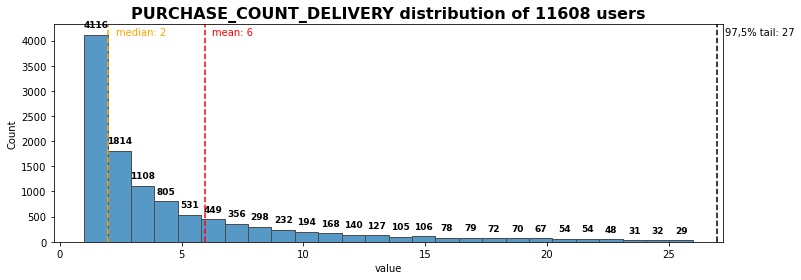

In [17]:
df_purchase = df[["PURCHASE_COUNT_DELIVERY"]]
df_purchase = df_purchase.query("PURCHASE_COUNT_DELIVERY > 0")
hist(df_purchase)

Sample size: 2035
Mean value: 2.2
Median value: 1.0
5%-tail limit: 8.0
Tail size: 85


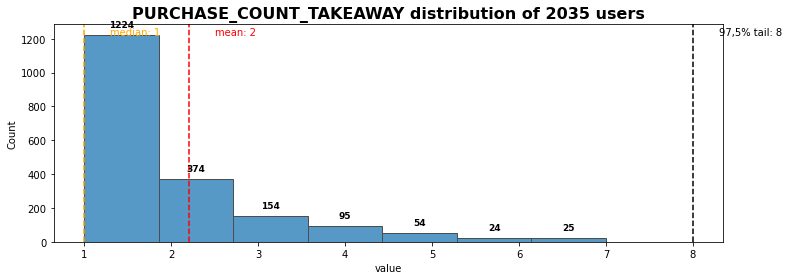

In [18]:
df_purchase = df[["PURCHASE_COUNT_TAKEAWAY"]]
df_purchase = df_purchase.query("PURCHASE_COUNT_TAKEAWAY > 0")
hist(df_purchase)

In [19]:
df_pur_type = df[[
    "PURCHASE_COUNT_TAKEAWAY", "PURCHASE_COUNT_DELIVERY", 
    "PURCHASE_COUNT", "USER_ID"
]]
df_pur_type["PURCHASE_COUNT_TAKEAWAY"] = df_pur_type["PURCHASE_COUNT_TAKEAWAY"].fillna(0)
df_pur_type["PURCHASE_COUNT_DELIVERY"] = df_pur_type["PURCHASE_COUNT_DELIVERY"].fillna(0)

df_pur_type["all_purchase_types"] = (
    df_pur_type["PURCHASE_COUNT_TAKEAWAY"] + df_pur_type["PURCHASE_COUNT_DELIVERY"] 
)

df_pur_type_equal = df_pur_type.query("all_purchase_types == PURCHASE_COUNT")
df_pur_type_not_equal = df_pur_type.query("all_purchase_types != PURCHASE_COUNT")
df_pur_type_not_equal.head()

,PURCHASE_COUNT_TAKEAWAY,PURCHASE_COUNT_DELIVERY,PURCHASE_COUNT,USER_ID,all_purchase_types


Do we have such users that preffered takeaway to delivery?

In [20]:
df_pur_type_equal.query("PURCHASE_COUNT_TAKEAWAY > PURCHASE_COUNT_DELIVERY").shape[0]

593

Do we have such users that preffered only takeaway?

In [21]:
df_pur_type_equal.query("PURCHASE_COUNT_TAKEAWAY > PURCHASE_COUNT_DELIVERY and PURCHASE_COUNT_DELIVERY == 0").shape[0]

420

Well, I'm not going to use it in segmentation due to the same reasons as have been mentioned above. 

### 2.2 BREAKFAST_PURCHASES, LUNCH_PURCHASES, EVENING_PURCHASES, DINNER_PURCHASES and LATE_NIGHT_PURCHASES

Is the amount of BREAKFAST_PURCHASES, LUNCH_PURCHASES, EVENING_PURCHASES, DINNER_PURCHASES and LATE_NIGHT_PURCHASES corresponds to PURCHASE_COUNT?

In [22]:
df_eattime = df[[
    "BREAKFAST_PURCHASES", "LUNCH_PURCHASES", "EVENING_PURCHASES", 
    "DINNER_PURCHASES", "LATE_NIGHT_PURCHASES", "PURCHASE_COUNT", "USER_ID"
]]
df_eattime["BREAKFAST_PURCHASES"] = df_eattime["BREAKFAST_PURCHASES"].fillna(0)
df_eattime["LUNCH_PURCHASES"] = df_eattime["LUNCH_PURCHASES"].fillna(0)
df_eattime["EVENING_PURCHASES"] = df_eattime["EVENING_PURCHASES"].fillna(0)
df_eattime["DINNER_PURCHASES"] = df_eattime["DINNER_PURCHASES"].fillna(0)
df_eattime["LATE_NIGHT_PURCHASES"] = df_eattime["LATE_NIGHT_PURCHASES"].fillna(0)

df_eattime["all_eattime"] = (
    df_eattime["BREAKFAST_PURCHASES"] + df_eattime["LUNCH_PURCHASES"] + df_eattime["EVENING_PURCHASES"] 
    + df_eattime["DINNER_PURCHASES"] + df_eattime["LATE_NIGHT_PURCHASES"] 
)
df_eattime_equal = df_eattime.query("all_eattime == PURCHASE_COUNT and PURCHASE_COUNT > 0")
df_eattime_not_equal = df_eattime.query("all_eattime != PURCHASE_COUNT")
df_eattime_not_equal.head()

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES,PURCHASE_COUNT,USER_ID,all_eattime
31,0.0,7.0,7.0,13.0,0.0,33,32,27.0
65,0.0,2.0,0.0,5.0,0.0,8,66,7.0
281,0.0,0.0,1.0,1.0,0.0,3,282,2.0
417,0.0,2.0,12.0,12.0,0.0,28,418,26.0
629,1.0,16.0,8.0,14.0,0.0,40,630,39.0


In [23]:
df_eattime_not_equal.shape[0]

211

In [24]:
df_eattime_equal.shape[0]

11817

Ok, 211 incorrect results out of 11817 seems to be a good result:) We can use it in segmentation. 

Sample size: 7185
Mean value: 3.81
Median value: 2.0
5%-tail limit: 17.0
Tail size: 235


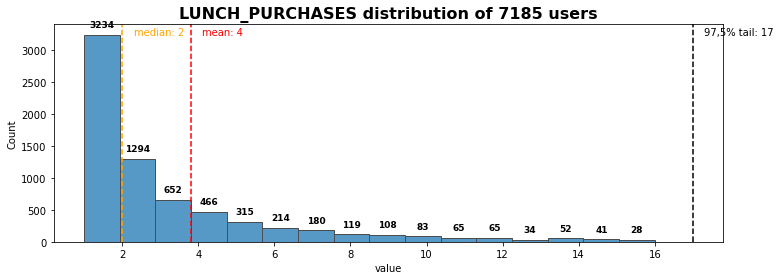

In [25]:
df_lunch = df_eattime_equal.query("LUNCH_PURCHASES > 0")
df_lunch = df_lunch[["LUNCH_PURCHASES"]]
hist(df_lunch)

### 2.3. MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE and MOST_COMMON_WEEKDAY_TO_PURCHASE

sample size: 12028


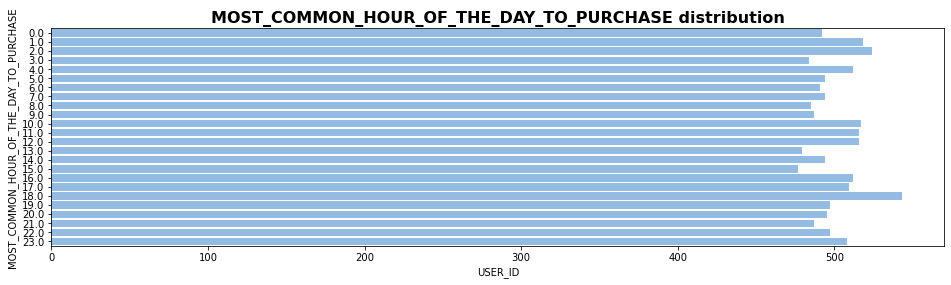

In [26]:
df_hour = df[["USER_ID", "PURCHASE_COUNT", "MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE"]]
df_hour = df_hour.query('PURCHASE_COUNT > 0')
df_hour = df_hour[["MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE", "USER_ID"]]
cat_hist(df_hour)

sample size: 12028


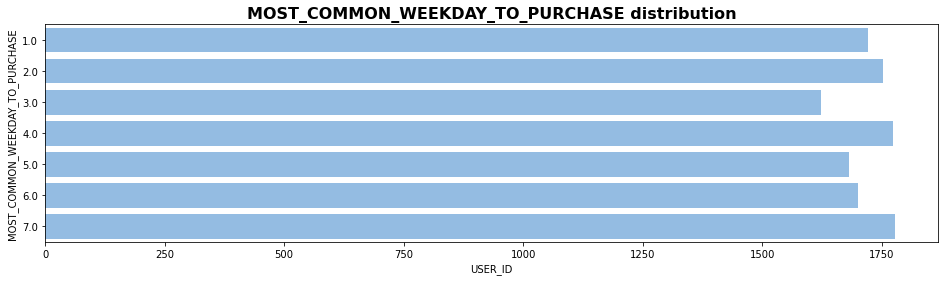

In [27]:
df_weekday = df[["USER_ID", "PURCHASE_COUNT", "MOST_COMMON_WEEKDAY_TO_PURCHASE"]]
df_weekday = df_weekday.query('PURCHASE_COUNT > 0')
df_weekday = df_weekday[["MOST_COMMON_WEEKDAY_TO_PURCHASE", "USER_ID"]]
cat_hist(df_weekday)

- MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE - I'm not going to use it because we have already had the categorication by breakfasts, lunch, etc.
- MOST_COMMON_WEEKDAY_TO_PURCHASE - probably it could be used in communication designing but I have no idea how to make it a part of clusterization.

### 2.4 PURCHASE_COUNT_BY_STORE_TYPE 

Let's divide it on separate columns and also check if the amount is the same as overall purchase count.

In [28]:
df_types = df[["PURCHASE_COUNT_BY_STORE_TYPE", "PURCHASE_COUNT", "USER_ID"]]
df_types["General_merchandise"] = 0
df_types["Grocery"] = 0
df_types["Pet_supplies"] = 0
df_types["Restaurant"] = 0
df_types["Retail_store"] = 0

for i in range(df_types.shape[0]):
    string = df_types.iloc[i]["PURCHASE_COUNT_BY_STORE_TYPE"]
    spl_str = (((string.replace(" ", "")).replace(",","")).replace("{","")).replace("}","").split("\n")
    
    fin_spl_str = spl_str[1].split(":")
    df_types.at[i, "General_merchandise"] = int(fin_spl_str[1])

    fin_spl_str = spl_str[2].split(":")
    df_types.at[i, "Grocery"] = int(fin_spl_str[1])

    fin_spl_str = spl_str[3].split(":")
    df_types.at[i, "Pet_supplies"] = int(fin_spl_str[1])
    
    fin_spl_str = spl_str[4].split(":")
    df_types.at[i, "Restaurant"] = int(fin_spl_str[1])
    
    fin_spl_str = spl_str[5].split(":")
    df_types.at[i, "Retail_store"] = int(fin_spl_str[1])    

df_types.head()

,PURCHASE_COUNT_BY_STORE_TYPE,PURCHASE_COUNT,USER_ID,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
0,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,1,0,0,0,0,0
1,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",1,2,0,0,0,1,0
2,"{\n ""General merchandise"": 1,\n ""Grocery"": 9...",19,3,1,9,0,9,0
3,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,4,0,0,0,0,0
4,"{\n ""General merchandise"": 0,\n ""Grocery"": 0...",0,5,0,0,0,0,0


In [29]:
df_types.query("PURCHASE_COUNT != General_merchandise + Grocery + Pet_supplies + Restaurant + Retail_store").head()

,PURCHASE_COUNT_BY_STORE_TYPE,PURCHASE_COUNT,USER_ID,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store


Sample size: 1857
Mean value: 7.82
Median value: 5.0
5%-tail limit: 24.0
Tail size: 61


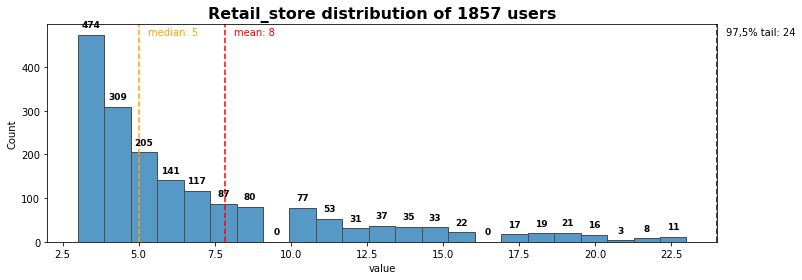

In [30]:
df_groc = df_types.query("Retail_store > 0")
df_groc = df_groc[["Retail_store"]]

hist(df_groc)

Well, it's also could be used in segmentation. 

### 2.5 DISTINCT_PURCHASE_VENUE_COUNT 

Sample size: 12028
Mean value: 3.32
Median value: 2.0
5%-tail limit: 11.0
Tail size: 588


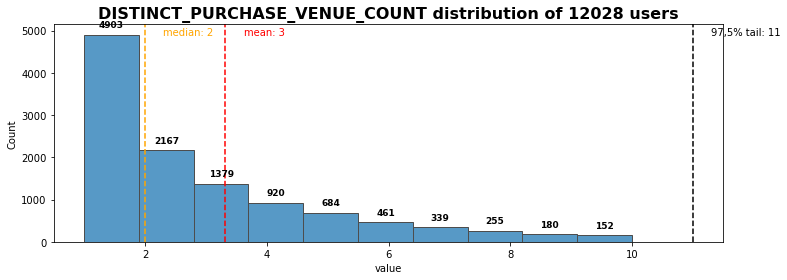

In [31]:
df_venue = df[["DISTINCT_PURCHASE_VENUE_COUNT"]]
df_venue = df_venue.query("DISTINCT_PURCHASE_VENUE_COUNT > 0")
hist(df_venue)

Consider that data should be useful in further steps of communication but not in primary reactivation. 

### 2.6 PREFERRED_RESTAURANT_TYPES

In [32]:
df_pref_res = df[["PREFERRED_RESTAURANT_TYPES", "USER_ID"]]
df_pref_res = df_pref_res.groupby("PREFERRED_RESTAURANT_TYPES").count()["USER_ID"].reset_index().sort_values(
    by = "USER_ID", ascending = False)
df_pref_res[:10]

,PREFERRED_RESTAURANT_TYPES,USER_ID
0,"[\n ""american""\n]",658
138,"[\n ""japanese""\n]",367
95,"[\n ""italian""\n]",345
181,"[\n ""mexican""\n]",175
8,"[\n ""american"",\n ""italian""\n]",131
76,"[\n ""indian""\n]",111
17,"[\n ""american"",\n ""italian"",\n ""mexican""\n]",62
205,"[\n ""middle eastern""\n]",58
96,"[\n ""italian"",\n ""american""\n]",51
31,"[\n ""american"",\n ""japanese""\n]",41


Consider it could be a part of design but not a part of clusterization.

### 3. Group of Behaviour Attributes 

- PURCHASE_COUNT
- TOTAL_PURCHASES_EUR
- MIN_PURCHASE_VALUE_EUR
- MAX_PURCHASE_VALUE_EUR
- AVG_PURCHASE_VALUE_EUR
- AVG_DAYS_BETWEEN_PURCHASES
- MEDIAN_DAYS_BETWEEN_PURCHASES
- FIRST_PURCHASE_DAY
- LAST_PURCHASE_DAY

### 3.1 PURCHASE_COUNT

Sample size: 12028
Mean value: 6.11
Median value: 3.0
5%-tail limit: 28.0
Tail size: 447


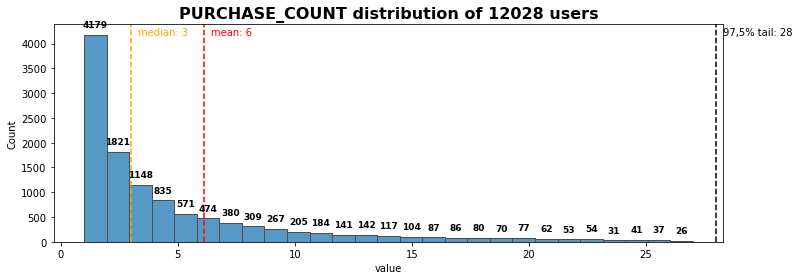

In [33]:
df_orders = df[["PURCHASE_COUNT"]]
df_orders = df_orders.query("PURCHASE_COUNT > 0")
hist(df_orders)

PURCHASE_COUNT - sure, one of the key attribute for segmentation.

### 3.2 TOTAL_PURCHASES_EUR, MIN_PURCHASE_VALUE_EUR, MAX_PURCHASE_VALUE_EUR, AVG_PURCHASE_VALUE_EUR

I'm not sure that we have any reason to explore min or max values, especially for customers with small number of orders. Consider it could be useful information in case when we want to create some tresholds of promocodes, disconts, etc. but not in these segmentation.

Here I'm going to evaluate the average receipt of customers' orders.

In [34]:
df_rec = df[["USER_ID", "TOTAL_PURCHASES_EUR", "PURCHASE_COUNT"]]
df_rec = df_rec.query("PURCHASE_COUNT > 0")
df_rec["average_receipt"] = round(df_rec["TOTAL_PURCHASES_EUR"] / df_rec["PURCHASE_COUNT"])
df_rec.head()

,USER_ID,TOTAL_PURCHASES_EUR,PURCHASE_COUNT,average_receipt
1,2,38.456,1,38.0
2,3,631.488,19,33.0
7,8,19.228,1,19.0
12,13,587.972,19,31.0
13,14,118.404,2,59.0


In [35]:
def hist_without_patches(df_input: tp.Any) -> tp.Any:
    """Vizualisation of variable's distribution"""

    col = df_input.columns[0]
    df_input = df_input.rename(columns = {col:"value"})

    """
    I'm going to cut off the tail of distribution.

    I will use z-score or standard score - basically it's the number of standard deviations, 
    by which the value is above or below the mean value of what is being measured. 
    Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores.

    The standard score is calculating by following approach: z = (x - Xavg) / S, 
    where x is a variable value, Xavg - an average value for full sample 
    (arithmetical mean: Xavg = sum(x) / N, where N is the observation number), S - a standart deviasion of full sample).

    S is the square root of standart variance, S = sqrt ( sum ((x - Xavg)^2) / N )
    """    
    #Xavg
    avg = df_input.mean().value 
    
    #(x - Xavg)^2
    df_input["sq"] = (df_input.value - avg) ** 2
    
    #N
    count = df_input.count().sq 
    
    #sum ((x - Xavg)^2)
    sq_sum = df_input.sum().sq
    
    #S
    S = ( sq_sum / (count) ) ** (1/2)
    
    #z-score
    df_input["z"] = (df_input.value - avg) / S
    
    v_mean = df_input.mean().value
    v_median = df_input.median().value
    v_count = df_input.count().value
    
    #cutting off the tail
    df_z = df_input.query("z > 1.96").reset_index()
    
    tail_count = df_z.count().value
    tail_limit = df_z.min().value
    
    #use it in further visualization
    df_viz = df_input.query("z <= 1.96").reset_index()
    
    #define the bins number and provide warnings in case of some problems
    if np.isnan(tail_limit) == False:
        bins_num = int(tail_limit) - 1
        
        #make charts readable again
        if bins_num < 20:
            bins_num = bins_num
        else:
            bins_num = 20    
    
        rcParams['figure.figsize'] = 12,4
    
        system_hist = sns.histplot(
            df_viz
            , x = df_viz.value
            , palette = "light:m_r"
            , edgecolor = ".3"
            , linewidth = 1
            , bins = int(tail_limit) - 1
        )

        plt.axvline(
            v_mean
            , color = 'red'
            , label = 'mean'
            , linestyle = '--'
        )
        plt.text(
            x = v_mean + 0.3
            , y = max([h.get_height() for h in system_hist.patches]) - 30
            , s = 'mean: {:.0f}'.format(v_mean)
            , color = 'red'
        )

        plt.axvline(
            v_median
            , color = 'orange'
            , label = 'median'
            , linestyle = '--'
        )
        plt.text(
            x = v_median + 0.3
            , y = max([h.get_height() for h in system_hist.patches])
            , s = 'median: {:.0f}'.format(v_median)
            , color = 'orange'
        )

        plt.axvline(
            tail_limit
            , color = 'black'
            , label = '5% tail'
            , linestyle = '--'
        )
        plt.text(
            x = tail_limit + 0.3
            , y = max([h.get_height() for h in system_hist.patches])
            , s = '97,5% tail: {:.0f}'.format(tail_limit)
            , color = 'black'
        )
        system_hist.set_title(col + " distribution of " + str(count) + " users", fontweight ="bold", size = 16)

    #exclusions    
    else:
        print("No distribution of " + col)

    
    return print(
        "Sample size: " + str(v_count)
        + "\n"
        + "Mean value: " + str(round(v_mean, 2)) 
        + "\n"
        + "Median value: " + str(round(v_median, 2))
        + "\n"
        + "5%-tail limit: " + str(round(tail_limit, 2))
        + "\n"
        + "Tail size: " + str(tail_count)
    )

Sample size: 12028
Mean value: 31.14
Median value: 27.0
5%-tail limit: 72.0
Tail size: 362


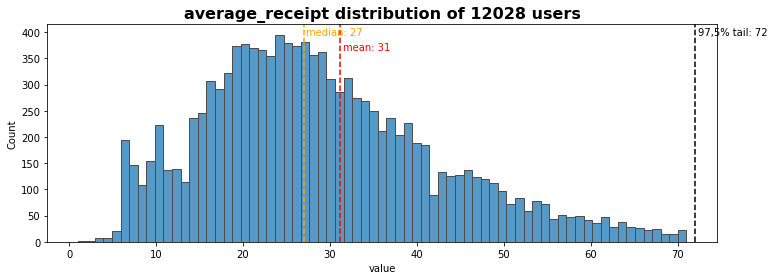

In [36]:
df_avg_rec = df_rec.query("average_receipt > 0")
df_avg_rec = df_avg_rec[["average_receipt"]]

hist_without_patches(df_avg_rec)

### 3.3 AVG_DAYS_BETWEEN_PURCHASES and MEDIAN_DAYS_BETWEEN_PURCHASES 

Sample size: 7832
Mean value: 55.79
Median value: 25.0
5%-tail limit: 203.0
Tail size: 445


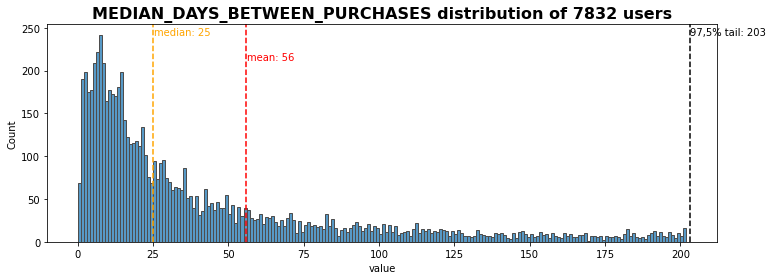

In [37]:
df_freq = df.query("PURCHASE_COUNT > 1")
df_freq = df_freq[["MEDIAN_DAYS_BETWEEN_PURCHASES"]]
hist_without_patches(df_freq)

###  FIRST_PURCHASE_DAY and LAST_PURCHASE_DAY

In [38]:
df_f_pur = df[["FIRST_PURCHASE_DAY", "USER_ID"]]
df_f_pur_min = df_f_pur.sort_values(by = "FIRST_PURCHASE_DAY", ascending = True)
df_f_pur_max = df_f_pur.sort_values(by = "FIRST_PURCHASE_DAY", ascending = False)

f_p_min = df_f_pur_min.iloc[0]["FIRST_PURCHASE_DAY"]
f_p_max = df_f_pur_max.iloc[0]["FIRST_PURCHASE_DAY"]

df_l_pur = df[["LAST_PURCHASE_DAY", "USER_ID"]]
df_l_pur_min = df_l_pur.sort_values(by = "LAST_PURCHASE_DAY", ascending = True)
df_l_pur_max = df_l_pur.sort_values(by = "LAST_PURCHASE_DAY", ascending = False)

f_l_min = df_l_pur_min.iloc[0]["LAST_PURCHASE_DAY"]
f_l_max = df_l_pur_max.iloc[0]["LAST_PURCHASE_DAY"]

print("First purchases of the sample were made from " 
      + f_p_min[:10]
      + " till "
      + f_p_max[:10]
      + "\n"
      + "Last purchaes of the sample were made from "
      + f_l_min[:10]
      + " till "
      + f_l_max[:10]
     )

First purchases of the sample were made from 2019-09-01 till 2020-10-31
Last purchaes of the sample were made from 2019-09-01 till 2020-10-31


Well, we have already had the frequency of orders and considered previously the cogort is one. So I'm not going to use dates of first and last purchases.

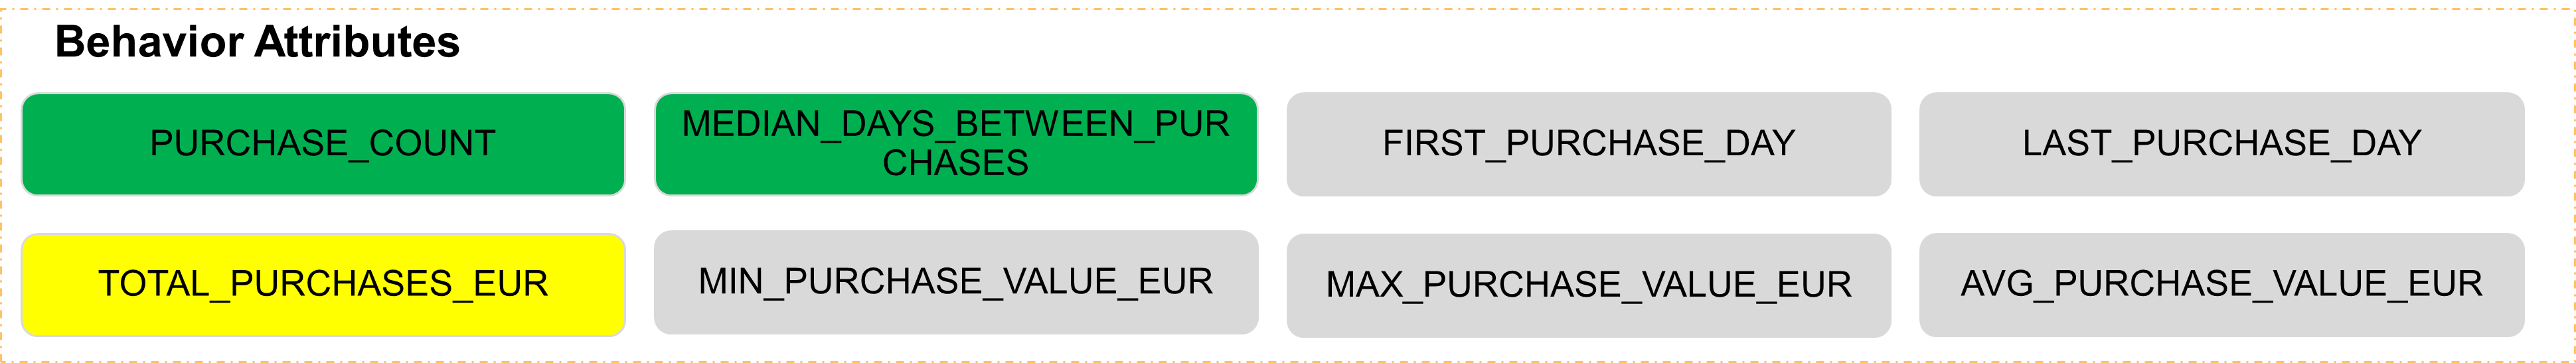

# Clusterization

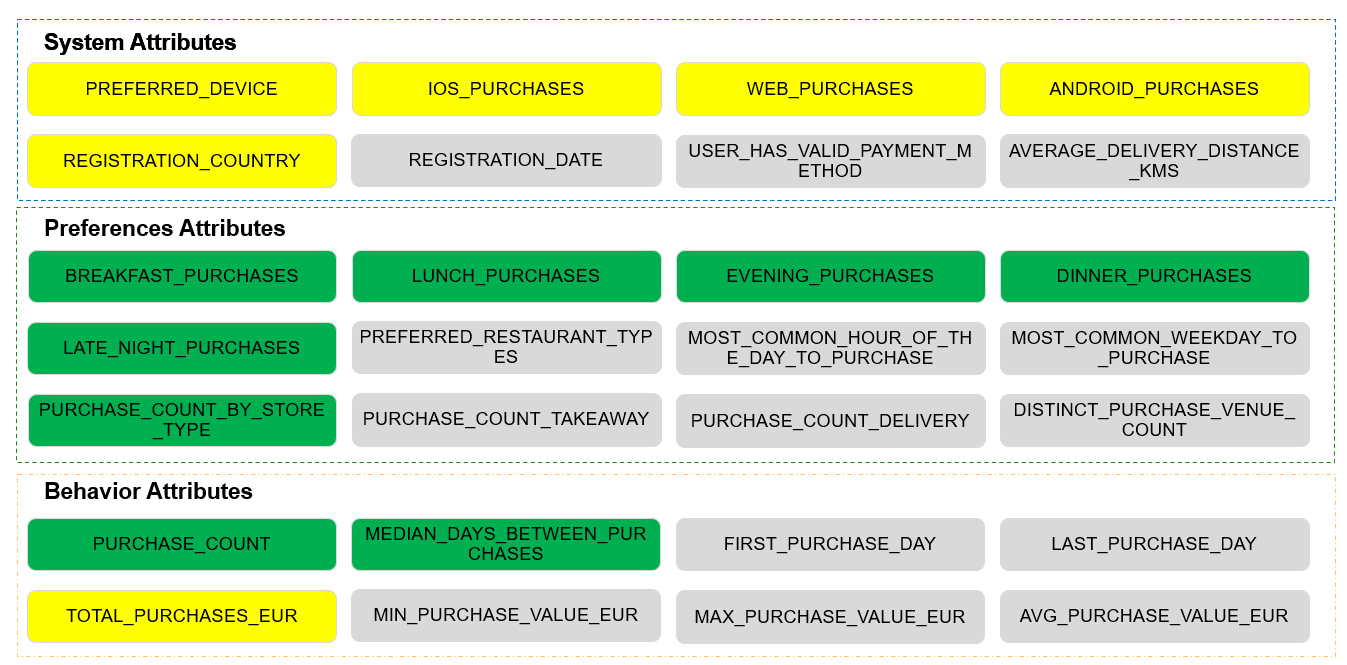

I'm going to use k-means for creating clusters of users based on previously selected attributes. 

For all type of data firstly I have to provide the number of clusters and then make the clusterization: I'm going to use the break of negative AIC and BIC dynamics trend. Let's see the overall example of overall number of orders and average receipts of customers.

In [39]:
def clusters_number(df_model: tp.Any) -> tp.Any: 
    """
    Choose the number which end the negative trend
    """
    aic = []
    bic = []
    #define number of clusters
    for i in range(1, 15):
        gmm_model = GaussianMixture(n_components = i, init_params = "kmeans", n_init = 10)
        gmm_model.fit(df_model)
        aic.append(gmm_model.aic(df_model))
        bic.append(gmm_model.bic(df_model))

    rcParams['figure.figsize'] = 16,9
    
    aic_bic = sns.lineplot(
        x = range(len(aic))
        , y = aic
        , label = "aic"
        , color = "black"
    )

    aic_bic = sns.lineplot(
        x = range(len(bic))
        , y = bic
        , label = "bic"
        , color = "orange"
        , linestyle = '--'
    )

    aic_bic.set_title("Lasso AIC-BIC model selection", fontweight ="bold", size = 16)
    
    return print("Minimal AIC: " + str(min(aic)) + ", minimal BIC: " + str(min(bic)))

Minimal AIC: 60322.47307702183, minimal BIC: 60891.88750291818


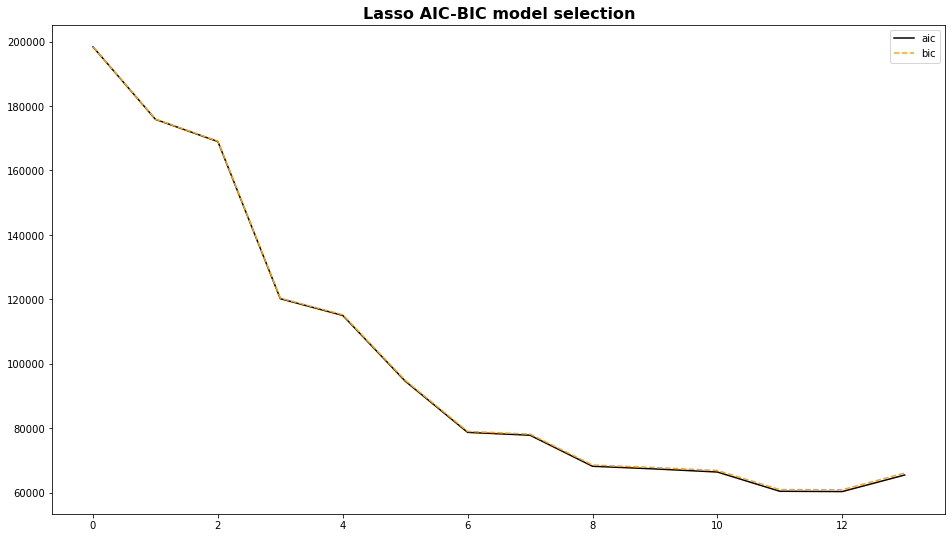

In [41]:
df_cl_rec_ord = df_rec[["USER_ID", "PURCHASE_COUNT", "average_receipt"]]
df_cl_rec_ord = df_cl_rec_ord.query("PURCHASE_COUNT > 0 and average_receipt > 0")
df_cl_rec_ord = df_cl_rec_ord.set_index("USER_ID")

clusters_number(df_cl_rec_ord)

In [42]:
def clusterization(df_model: tp.Any, n_clusters: int) -> tp.Any: 
    
    gmm_model = GaussianMixture(n_components = n_clusters, init_params = "kmeans", n_init = 10)
    gmm_model.fit(df_model)
    cluster_labels = gmm_model.predict(df_model)
    df_model['cluster'] = cluster_labels

    rcParams['figure.figsize'] = 16,9
    
    for k in range(n_clusters):
        data = df_model[df_model["cluster"] == k]
        
        
        fin_viz = sns.scatterplot(
            x = data.columns[0]
            , y = data.columns[1]
            , palette = "ch:r=-.2,d=.3_r"
            , linewidth = 0
            , data = data
            , label = k
            )

    fin_viz.set_xlim(left = 0, right = 100)
    fin_viz.set_ylim(bottom = 0, top = 200)
    fin_viz.set_title("Clusterization result", fontweight ="bold", size = 16)
        
    return df_model

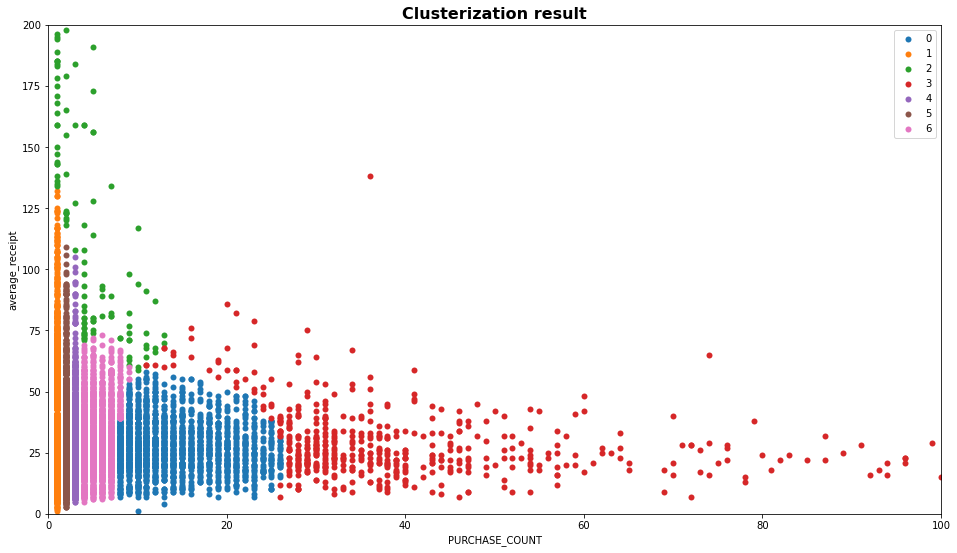

In [43]:
df_clust = clusterization(df_cl_rec_ord, 7)

In [44]:
clust_avg = df_clust.groupby("cluster").median()
clust_avg

,PURCHASE_COUNT,average_receipt
cluster,,
0,12,27.0
1,1,26.0
2,4,117.0
3,35,25.0
4,3,29.0
5,2,28.0
6,5,29.0


In [45]:
clust_group = df_clust.groupby("cluster").count()
clust_group

,PURCHASE_COUNT,average_receipt
cluster,,
0,1995,1995
1,4145,4145
2,121,121
3,526,526
4,1143,1143
5,1809,1809
6,2289,2289


In [46]:
def clusterization_no_graph(df_model: tp.Any, n_clusters: int) -> tp.Any: 
    
    gmm_model = GaussianMixture(n_components = n_clusters, init_params = "kmeans", n_init = 10)
    gmm_model.fit(df_model)
    cluster_labels = gmm_model.predict(df_model)
    df_model['cluster'] = cluster_labels
        
    return df_model

# Finalizing Dataset

## 1. Dividing users by countries

Will be used properly in segmentation.

In [47]:
df_segment = df.copy()

df_segment["country"] = ""

for i in range(df_segment.shape[0]):
    if df_segment.at[i, "REGISTRATION_COUNTRY"] not in ("FIN", "DNK", "GRC"):
        df_segment.at[i, "country"] = "other"
    else:
        df_segment.at[i, "country"] = df_segment.at[i, "REGISTRATION_COUNTRY"] 

## 2. Dividing users by purchase fact

Will be used properly in segmentation.

In [48]:
df_segment["has_purchase"] = ""

for i in range(df_segment.shape[0]):
    if df_segment.at[i, "PURCHASE_COUNT"] > 0:
        df_segment.at[i, "has_purchase"] = True
    else:
        df_segment.at[i, "has_purchase"] = False

## 3. Replacing preferred devices

Not a part of segmentation but useful for communication designing. 

In [49]:
df_segment["IOS_PURCHASES"] = df_segment["IOS_PURCHASES"].fillna(0)
df_segment["WEB_PURCHASES"] = df_segment["WEB_PURCHASES"].fillna(0)
df_segment["ANDROID_PURCHASES"] = df_segment["ANDROID_PURCHASES"].fillna(0)

df_segment["device"] = ""
for i in range(df_segment.shape[0]):    
    if df_segment.at[i, "IOS_PURCHASES"] > df_segment.at[i, "WEB_PURCHASES"] and df_segment.at[i, "IOS_PURCHASES"] > df_segment.at[i, "ANDROID_PURCHASES"]:
        df_segment.at[i, "device"] = "ios"
    elif df_segment.at[i, "ANDROID_PURCHASES"] > df_segment.at[i, "WEB_PURCHASES"] and df_segment.at[i, "ANDROID_PURCHASES"] > df_segment.at[i, "IOS_PURCHASES"]:
        df_segment.at[i, "device"] = "android"
    elif df_segment.at[i, "WEB_PURCHASES"] > df_segment.at[i, "IOS_PURCHASES"] and df_segment.at[i, "WEB_PURCHASES"] > df_segment.at[i, "ANDROID_PURCHASES"]:
          df_segment.at[i, "device"] = "web"
    else:
        df_segment.at[i, "device"] = df_segment.at[i, "PREFERRED_DEVICE"]


## 4. Dividing  PURCHASE_COUNT_BY_STORE_TYPE to separate columns 

Will be used in kmeans.

In [50]:
df_segment["General_merchandise"] = 0
df_segment["Grocery"] = 0
df_segment["Pet_supplies"] = 0
df_segment["Restaurant"] = 0
df_segment["Retail_store"] = 0

for i in range(df_segment.shape[0]):
    string = df_segment.iloc[i]["PURCHASE_COUNT_BY_STORE_TYPE"]
    spl_str = (((string.replace(" ", "")).replace(",","")).replace("{","")).replace("}","").split("\n")
    
    fin_spl_str = spl_str[1].split(":")
    df_segment.at[i, "General_merchandise"] = int(fin_spl_str[1])

    fin_spl_str = spl_str[2].split(":")
    df_segment.at[i, "Grocery"] = int(fin_spl_str[1])

    fin_spl_str = spl_str[3].split(":")
    df_segment.at[i, "Pet_supplies"] = int(fin_spl_str[1])
    
    fin_spl_str = spl_str[4].split(":")
    df_segment.at[i, "Restaurant"] = int(fin_spl_str[1])
    
    fin_spl_str = spl_str[5].split(":")
    df_segment.at[i, "Retail_store"] = int(fin_spl_str[1])

## 5. Completing average_receipt

In [51]:
df_segment["average_receipt"] = 0

for i in range(df_segment.shape[0]):
    if df_segment.at[i, "PURCHASE_COUNT"] == 0:
        df_segment.at[i, "average_receipt"] = 0
    else:
        df_segment.at[i, "average_receipt"] = round(df_segment.at[i, "TOTAL_PURCHASES_EUR"] / df_segment.at[i, "PURCHASE_COUNT"])

In [52]:
df_cluster = df_segment[[
    "USER_ID", "country", "has_purchase", "device",
    "PURCHASE_COUNT", "average_receipt", "MEDIAN_DAYS_BETWEEN_PURCHASES", 
    "General_merchandise", "Grocery", "Pet_supplies", "Restaurant", "Retail_store",
    "BREAKFAST_PURCHASES", "LUNCH_PURCHASES", "EVENING_PURCHASES", "DINNER_PURCHASES", "LATE_NIGHT_PURCHASES" 
]]

In [53]:
df_cluster.head()

,USER_ID,country,has_purchase,device,PURCHASE_COUNT,average_receipt,MEDIAN_DAYS_BETWEEN_PURCHASES,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
0,1,DNK,False,ios,0,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2,FIN,True,android,1,38,NaN,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0
2,3,DNK,True,web,19,33,3.0,1,9,0,9,0,0.0,4.0,1.0,14.0,0.0
3,4,FIN,False,android,0,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,5,GRC,False,android,0,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


# Results of User Segmentation 

### Dividing by countries 

In [54]:
df_dnk = df_cluster.query("country =='DNK'")
df_fin = df_cluster.query("country =='FIN'")
df_grc = df_cluster.query("country =='GRC'")
df_oth = df_cluster.query("country =='other'")

### Dividing by at least one order 

In [55]:
df_dnk_pur = df_dnk.query("PURCHASE_COUNT > 0")
df_dnk_not_pur = df_dnk.query("PURCHASE_COUNT == 0")

df_fin_pur = df_fin.query("PURCHASE_COUNT > 0")
df_fin_not_pur = df_fin.query("PURCHASE_COUNT == 0")

df_grc_pur = df_grc.query("PURCHASE_COUNT > 0")
df_grc_not_pur = df_grc.query("PURCHASE_COUNT == 0")

## Store type clusters 

### Denmark 

Minimal AIC: -248205.5673595009, minimal BIC: -246296.9100755589


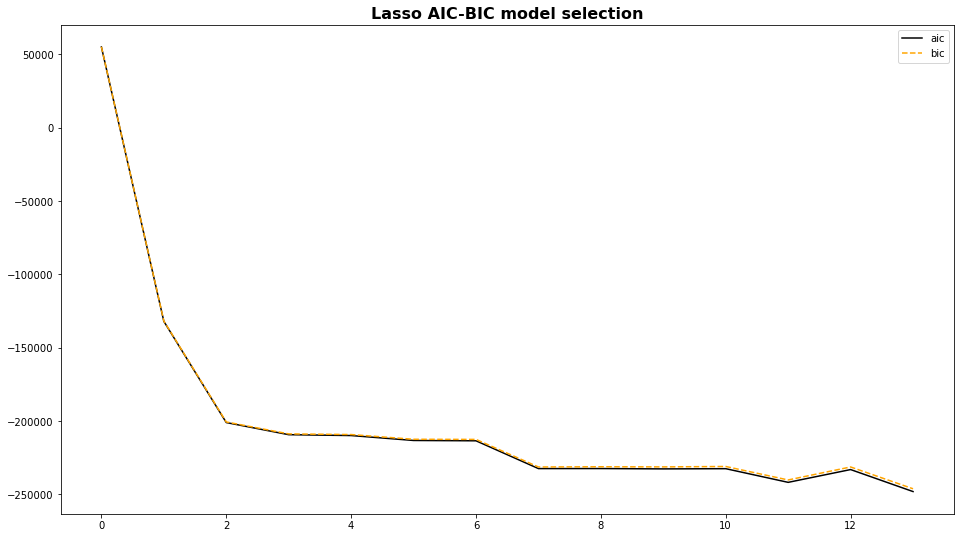

In [56]:
df_st = df_dnk_pur[["USER_ID", "General_merchandise", "Grocery", "Pet_supplies", "Restaurant", "Retail_store"]]
df_st = df_st.set_index("USER_ID")
clusters_number(df_st)

In [57]:
df_st_res = clusterization_no_graph(df_st, 3)

In [58]:
clust_avg = df_st_res.groupby("cluster").median()
clust_avg

,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
cluster,,,,,
0,0,0,0,5,5
1,0,0,0,2,0
2,1,5,0,5,0


In [59]:
clust_cnt = df_st_res.groupby("cluster").count()
clust_cnt

,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
cluster,,,,,
0,727,727,727,727,727
1,3608,3608,3608,3608,3608
2,650,650,650,650,650


In [60]:
df_st_dnk = df_st_res.copy()
df_st_dnk = df_st_dnk.reset_index()
df_st_dnk = df_st_dnk[["USER_ID", "cluster"]]

df_st_dnk["store_cluster"] = ""
for i in range(df_st_dnk.shape[0]):
    if df_st_dnk.at[i, "cluster"] == 0:
        df_st_dnk.at[i, "store_cluster"] = "restaurant"
    elif df_st_dnk.at[i, "cluster"] == 1:
        df_st_dnk.at[i, "store_cluster"] = "restaurant, retail"
    elif df_st_dnk.at[i, "cluster"] == 2:
        df_st_dnk.at[i, "store_cluster"] = "restaurant, grocery"
    else:
        continue
df_st_dnk.head()

,USER_ID,cluster,store_cluster
0,3,2,"restaurant, grocery"
1,18,1,"restaurant, retail"
2,42,1,"restaurant, retail"
3,46,1,"restaurant, retail"
4,76,1,"restaurant, retail"


### Finland 

Minimal AIC: -253513.23118344927, minimal BIC: -251701.5614995499


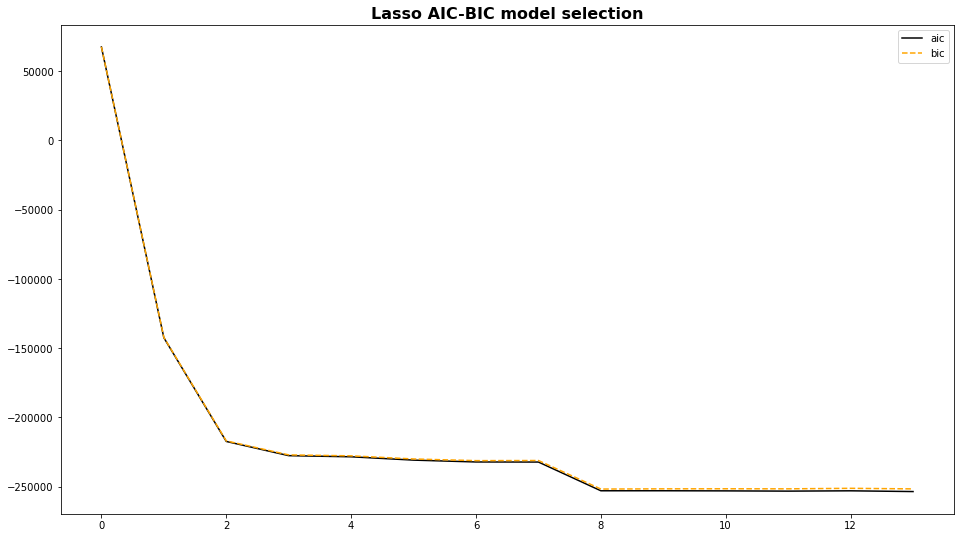

In [61]:
df_st = df_fin_pur[["USER_ID", "General_merchandise", "Grocery", "Pet_supplies", "Restaurant", "Retail_store"]]
df_st = df_st.set_index("USER_ID")
clusters_number(df_st)

In [62]:
df_st_res = clusterization_no_graph(df_st, 3)

In [63]:
clust_avg = df_st_res.groupby("cluster").median()
clust_avg

,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
cluster,,,,,
0,0,0,0,2,0
1,0,0,0,5,5
2,1,6,0,6,0


In [64]:
clust_cnt = df_st_res.groupby("cluster").count()
clust_cnt

,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
cluster,,,,,
0,3793,3793,3793,3793,3793
1,887,887,887,887,887
2,771,771,771,771,771


In [65]:
df_st_fin = df_st_res.copy()
df_st_fin = df_st_fin.reset_index()
df_st_fin = df_st_fin[["USER_ID", "cluster"]]

df_st_fin["store_cluster"] = ""
for i in range(df_st_fin.shape[0]):
    if df_st_fin.at[i, "cluster"] == 1:
        df_st_fin.at[i, "store_cluster"] = "restaurant"
    elif df_st_fin.at[i, "cluster"] == 0:
        df_st_fin.at[i, "store_cluster"] = "restaurant, retail"
    elif df_st_fin.at[i, "cluster"] == 2:
        df_st_fin.at[i, "store_cluster"] = "restaurant, grocery"
    else:
        continue
df_st_fin.head()

,USER_ID,cluster,store_cluster
0,2,0,"restaurant, retail"
1,8,0,"restaurant, retail"
2,13,2,"restaurant, grocery"
3,14,0,"restaurant, retail"
4,16,0,"restaurant, retail"


### Greece 

Minimal AIC: -71566.91241640635, minimal BIC: -70335.99475064575


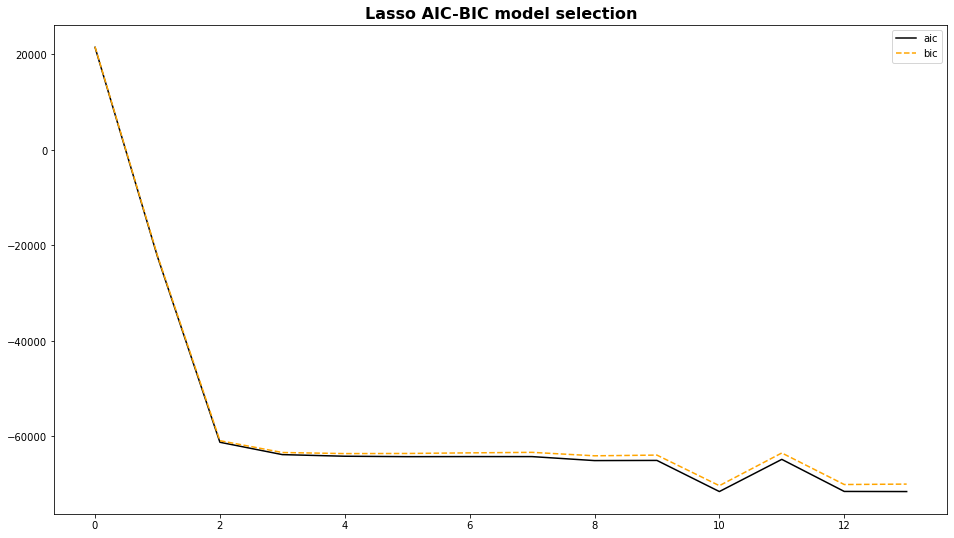

In [66]:
df_st = df_grc_pur[["USER_ID", "General_merchandise", "Grocery", "Pet_supplies", "Restaurant", "Retail_store"]]
df_st = df_st.set_index("USER_ID")
clusters_number(df_st)

In [67]:
df_st_res = clusterization_no_graph(df_st, 3)

In [68]:
clust_avg = df_st_res.groupby("cluster").median()
clust_avg

,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
cluster,,,,,
0,0,0,0,1,0
1,0,0,0,5,5
2,1,6,0,6,0


In [69]:
clust_cnt = df_st_res.groupby("cluster").count()
clust_cnt

,General_merchandise,Grocery,Pet_supplies,Restaurant,Retail_store
cluster,,,,,
0,1110,1110,1110,1110,1110
1,234,234,234,234,234
2,188,188,188,188,188


In [70]:
df_st_grc = df_st_res.copy()
df_st_grc = df_st_grc.reset_index()
df_st_grc = df_st_grc[["USER_ID", "cluster"]]

df_st_grc["store_cluster"] = ""
for i in range(df_st_grc.shape[0]):
    if df_st_grc.at[i, "cluster"] == 0:
        df_st_grc.at[i, "store_cluster"] = "restaurant"
    elif df_st_grc.at[i, "cluster"] == 1:
        df_st_grc.at[i, "store_cluster"] = "restaurant, retail"
    elif df_st_grc.at[i, "cluster"] == 2:
        df_st_grc.at[i, "store_cluster"] = "restaurant, grocery"
    else:
        continue
df_st_grc.head()

,USER_ID,cluster,store_cluster
0,21,0,restaurant
1,34,0,restaurant
2,43,0,restaurant
3,51,0,restaurant
4,55,0,restaurant


## Daytime cluster 

### Denmark 

Minimal AIC: -161105.26630498146, minimal BIC: -159607.00290803038


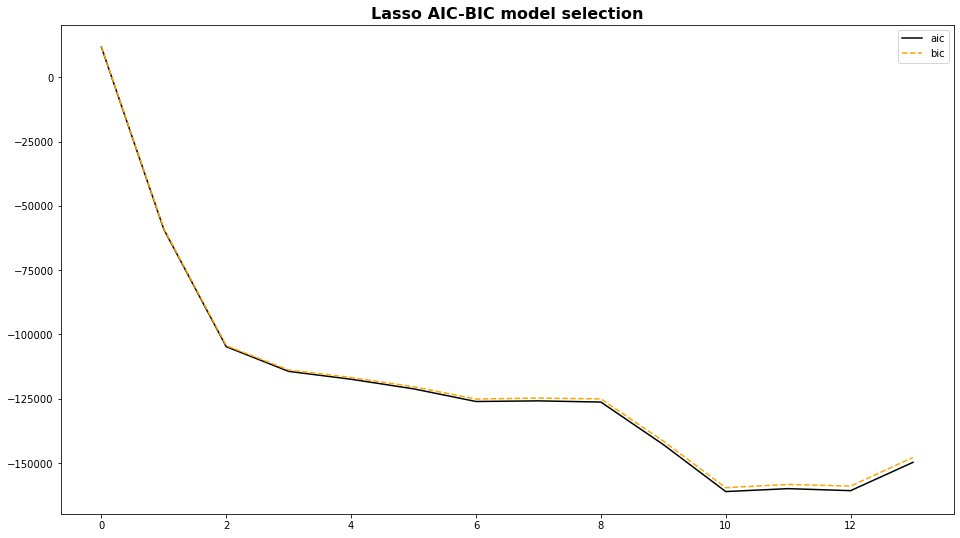

In [71]:
df_dt = df_dnk_pur[["USER_ID", "BREAKFAST_PURCHASES", "LUNCH_PURCHASES", "EVENING_PURCHASES", "DINNER_PURCHASES", "LATE_NIGHT_PURCHASES"]]
df_dt = df_dt.set_index("USER_ID")
clusters_number(df_dt)

In [72]:
df_dt_res = clusterization_no_graph(df_dt, 6)

In [73]:
clust_avg = df_dt_res.groupby("cluster").median()
clust_avg

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
cluster,,,,,
0,0.0,0.0,0.0,1.0,0.0
1,0.0,6.0,0.0,12.0,0.0
2,0.0,10.0,3.0,18.5,0.0
3,2.0,9.0,0.0,5.0,0.0
4,0.0,1.0,1.0,3.0,0.0
5,1.0,2.0,0.0,3.0,0.0


In [74]:
clust_cnt = df_dt_res.groupby("cluster").count()
clust_cnt

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
cluster,,,,,
0,4046,4046,4046,4046,4046
1,300,300,300,300,300
2,88,88,88,88,88
3,55,55,55,55,55
4,321,321,321,321,321
5,175,175,175,175,175


In [75]:
df_dt_dnk = df_dt_res.copy()
df_dt_dnk = df_dt_dnk.reset_index()
df_dt_dnk = df_dt_dnk[["USER_ID", "cluster"]]

df_dt_dnk["daytime_cluster"] = ""
for i in range(df_dt_dnk.shape[0]):
    if df_dt_dnk.at[i, "cluster"] in (1, 3, 4, 5):
        df_dt_dnk.at[i, "daytime_cluster"] = "Dinner and Lunch"
    else:
        continue
df_dt_dnk.head()

,USER_ID,cluster,daytime_cluster
0,3,4,Dinner and Lunch
1,18,0,
2,42,0,
3,46,0,
4,76,0,


### Finland

Minimal AIC: -117250.37210097499, minimal BIC: -115315.53067435515


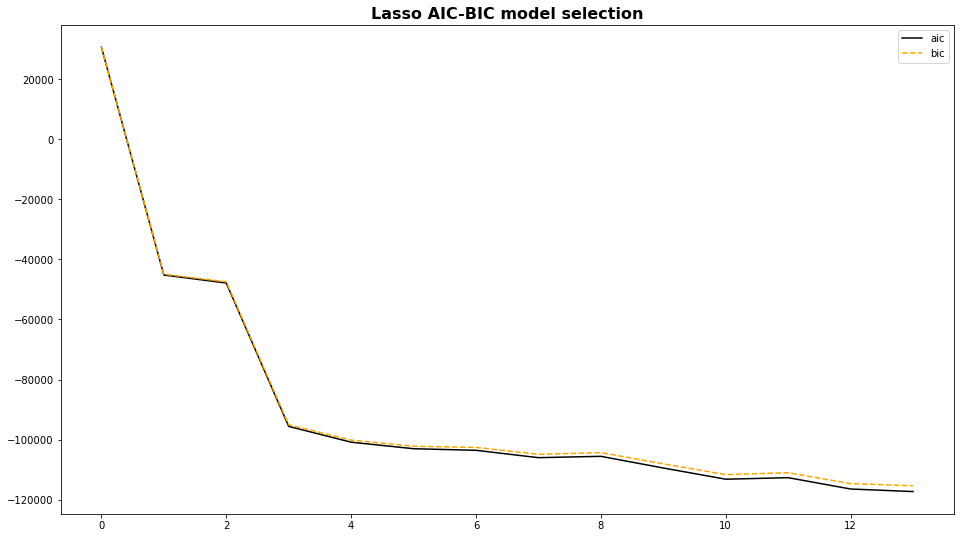

In [76]:
df_dt = df_fin_pur[["USER_ID", "BREAKFAST_PURCHASES", "LUNCH_PURCHASES", "EVENING_PURCHASES", "DINNER_PURCHASES", "LATE_NIGHT_PURCHASES"]]
df_dt = df_dt.set_index("USER_ID")
clusters_number(df_dt)

In [77]:
df_dt_res = clusterization_no_graph(df_dt, 4)

In [78]:
clust_avg = df_dt_res.groupby("cluster").median()
clust_avg

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
cluster,,,,,
0,0.0,1.0,0.0,1.0,0.0
1,1.0,13.0,2.0,10.0,0.0
2,1.0,2.0,0.0,1.0,0.0
3,0.0,2.0,1.0,3.0,0.0


In [79]:
clust_cnt = df_dt_res.groupby("cluster").count()
clust_cnt

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
cluster,,,,,
0,3479,3479,3479,3479,3479
1,297,297,297,297,297
2,440,440,440,440,440
3,1235,1235,1235,1235,1235


In [80]:
df_dt_fin = df_dt_res.copy()
df_dt_fin = df_dt_fin.reset_index()
df_dt_fin = df_dt_fin[["USER_ID", "cluster"]]

df_dt_fin["daytime_cluster"] = ""
for i in range(df_dt_fin.shape[0]):
    if df_dt_fin.at[i, "cluster"] in (1, 2):
        df_dt_fin.at[i, "daytime_cluster"] = "Dinner and Lunch"
    else:
        continue
df_dt_fin.head()

,USER_ID,cluster,daytime_cluster
0,2,0,
1,8,3,
2,13,3,
3,14,3,
4,16,0,


### Greece 

Minimal AIC: -26994.30816524486, minimal BIC: -25543.370581963114


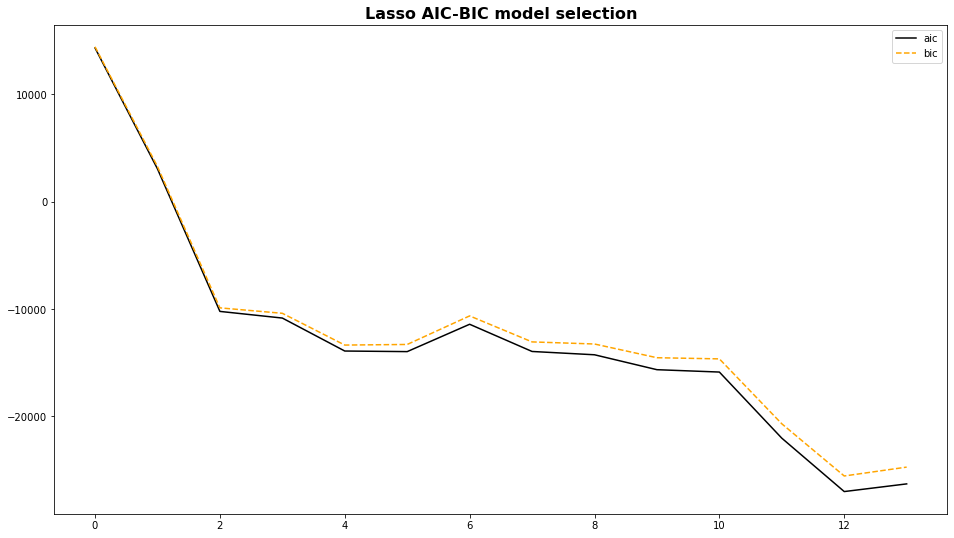

In [81]:
df_dt = df_grc_pur[["USER_ID", "BREAKFAST_PURCHASES", "LUNCH_PURCHASES", "EVENING_PURCHASES", "DINNER_PURCHASES", "LATE_NIGHT_PURCHASES"]]
df_dt = df_dt.set_index("USER_ID")
clusters_number(df_dt)

In [82]:
df_dt_res = clusterization_no_graph(df_dt, 4)

In [83]:
clust_avg = df_dt_res.groupby("cluster").median()
clust_avg

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
cluster,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,1.0,2.0,1.0,2.0,0.0
2,4.5,30.0,12.5,12.5,0.0
3,2.0,9.0,2.0,5.0,0.0


In [84]:
clust_cnt = df_dt_res.groupby("cluster").count()
clust_cnt

,BREAKFAST_PURCHASES,LUNCH_PURCHASES,EVENING_PURCHASES,DINNER_PURCHASES,LATE_NIGHT_PURCHASES
cluster,,,,,
0,1125,1125,1125,1125,1125
1,245,245,245,245,245
2,28,28,28,28,28
3,134,134,134,134,134


In [85]:
df_dt_grc = df_dt_res.copy()
df_dt_grc = df_dt_grc.reset_index()
df_dt_grc = df_dt_grc[["USER_ID", "cluster"]]

df_dt_grc["daytime_cluster"] = ""
for i in range(df_dt_grc.shape[0]):
    if df_dt_grc.at[i, "cluster"] in (1, 2):
        df_dt_grc.at[i, "daytime_cluster"] = "Dinner and Lunch"
    else:
        continue
df_dt_grc.head()

,USER_ID,cluster,daytime_cluster
0,21,0,
1,34,0,
2,43,0,
3,51,0,
4,55,1,Dinner and Lunch


## Behavior cluster 

## Denmark 

Minimal AIC: 22122.129484746394, minimal BIC: 22662.807145385257


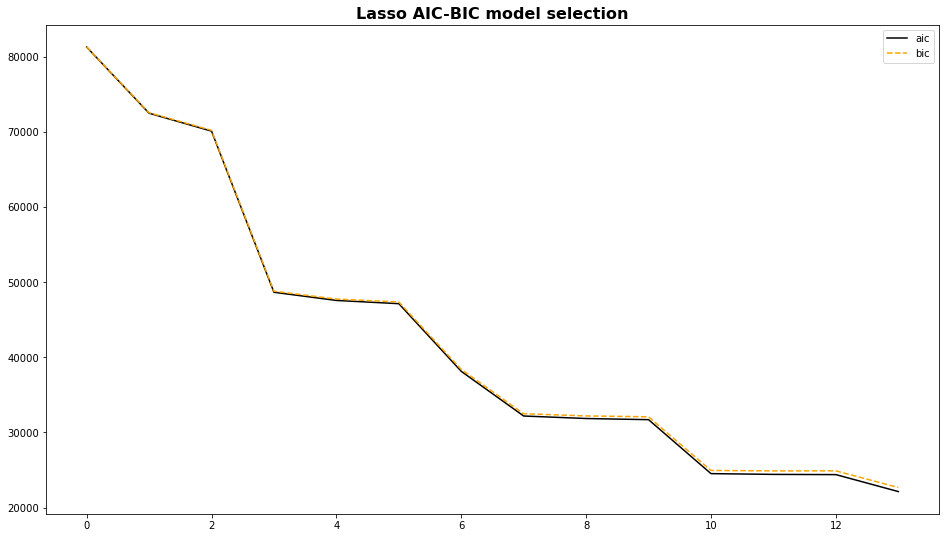

In [86]:
df_dnk_rec_ord = df_dnk_pur[["USER_ID", "PURCHASE_COUNT", "average_receipt"]]
df_dnk_rec_ord = df_dnk_rec_ord.set_index("USER_ID")

clusters_number(df_dnk_rec_ord)

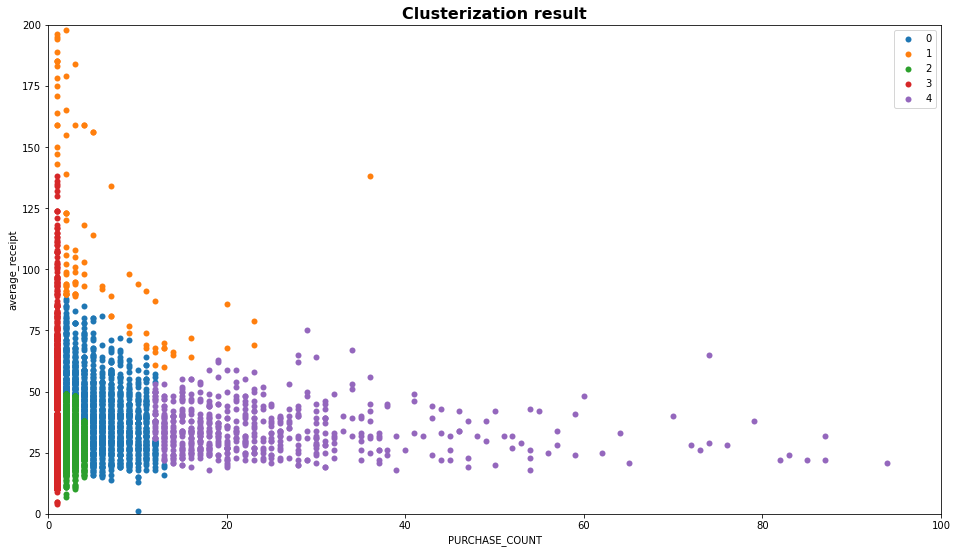

In [87]:
df_clust = clusterization(df_dnk_rec_ord, 5)

In [88]:
clust_avg = df_clust.groupby("cluster").median()
clust_avg

,PURCHASE_COUNT,average_receipt
cluster,,
0,6,40
1,3,99
2,3,30
3,1,33
4,20,33


In [89]:
clust_group = df_clust.groupby("cluster").count()
clust_group

,PURCHASE_COUNT,average_receipt
cluster,,
0,1393,1393
1,102,102
2,1218,1218
3,1696,1696
4,576,576


In [90]:
df_beh_dnk = df_clust.copy()
df_beh_dnk = df_beh_dnk.reset_index()
df_beh_dnk = df_beh_dnk[["USER_ID", "cluster"]]

df_beh_dnk["behavior"] = ""
for i in range(df_beh_dnk.shape[0]):
    if df_beh_dnk.at[i, "cluster"] == 0:
        df_beh_dnk.at[i, "store_cluster"] = "few orders, low check"
    elif df_beh_dnk.at[i, "cluster"] == 1:
        df_beh_dnk.at[i, "store_cluster"] = "1 order, low check"
    elif df_beh_dnk.at[i, "cluster"] == 2:
        df_beh_dnk.at[i, "store_cluster"] = "1 order, high check"
    elif df_beh_dnk.at[i, "cluster"] == 3:
        df_beh_dnk.at[i, "store_cluster"] = "medium orders, medium check"
    elif df_beh_dnk.at[i, "cluster"] == 4:
        df_beh_dnk.at[i, "store_cluster"] = "many orders, small check"
    else:
        continue
df_beh_dnk.head()

,USER_ID,cluster,behavior,store_cluster
0,3,4,,"many orders, small check"
1,18,0,,"few orders, low check"
2,42,3,,"medium orders, medium check"
3,46,3,,"medium orders, medium check"
4,76,3,,"medium orders, medium check"


## Finland

Minimal AIC: 26078.996260708453, minimal BIC: 26627.091272344787


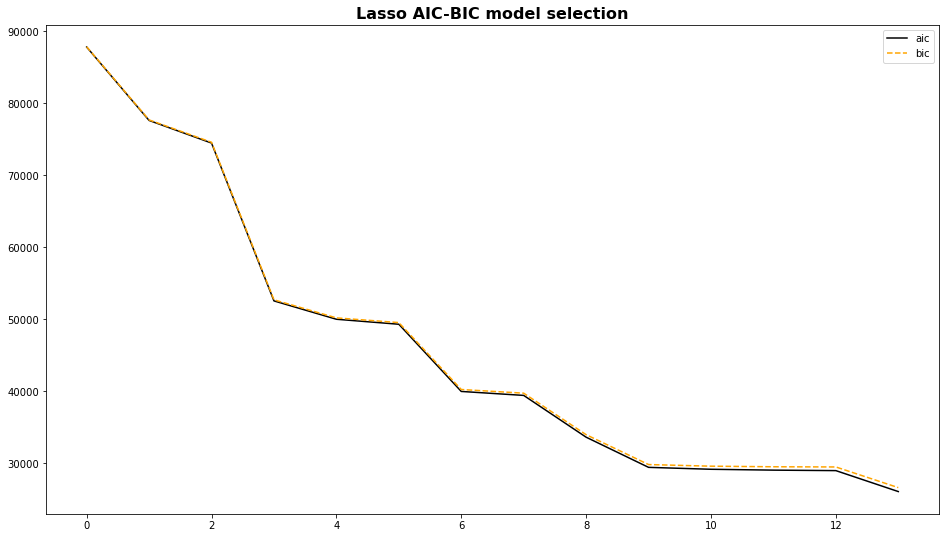

In [91]:
df_fin_rec_ord = df_fin_pur[["USER_ID", "PURCHASE_COUNT", "average_receipt"]]
df_fin_rec_ord = df_fin_rec_ord.set_index("USER_ID")

clusters_number(df_fin_rec_ord)

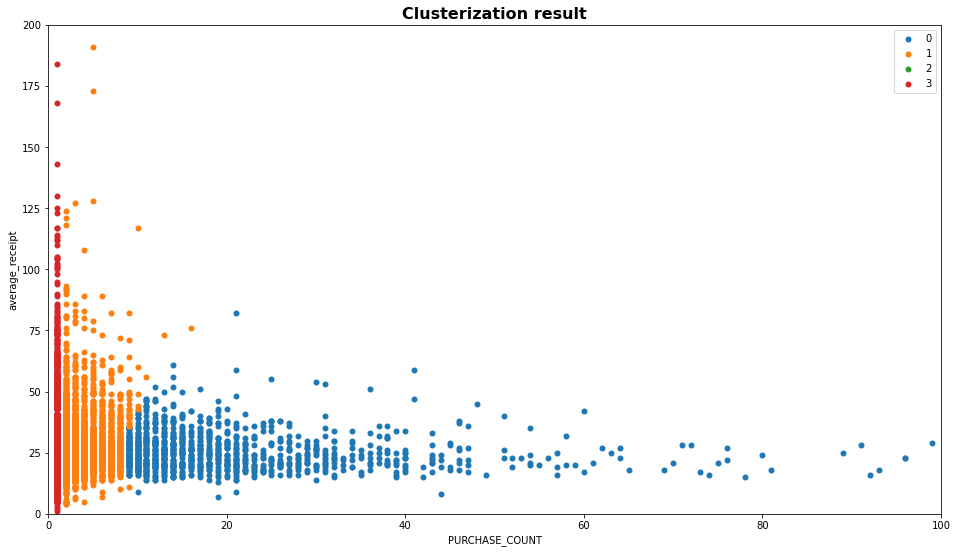

In [92]:
df_clust = clusterization(df_fin_rec_ord, 4)

In [93]:
clust_avg = df_clust.groupby("cluster").median()
clust_avg

,PURCHASE_COUNT,average_receipt
cluster,,
0,16,24
1,3,27
2,14,570
3,1,24


In [94]:
clust_group = df_clust.groupby("cluster").count()
clust_group

,PURCHASE_COUNT,average_receipt
cluster,,
0,1071,1071
1,2510,2510
2,1,1
3,1869,1869


In [95]:
df_beh_fin = df_clust.copy()
df_beh_fin = df_beh_fin.reset_index()
df_beh_fin = df_beh_fin[["USER_ID", "cluster"]]

df_beh_fin["behavior"] = ""
for i in range(df_beh_fin.shape[0]):
    if df_beh_fin.at[i, "cluster"] == 0:
        df_beh_fin.at[i, "store_cluster"] = "1 order, low check"
    elif df_beh_fin.at[i, "cluster"] == 1:
        df_beh_fin.at[i, "store_cluster"] = "medium orders, low check"
    elif df_beh_fin.at[i, "cluster"] == 2:
        df_beh_fin.at[i, "store_cluster"] = "low orders, high check"
    elif df_beh_fin.at[i, "cluster"] == 3:
        df_beh_fin.at[i, "store_cluster"] = "many orders, low check"
    else:
        continue
df_beh_fin.head()

,USER_ID,cluster,behavior,store_cluster
0,2,3,,"many orders, low check"
1,8,3,,"many orders, low check"
2,13,0,,"1 order, low check"
3,14,1,,"medium orders, low check"
4,16,1,,"medium orders, low check"


## Greece 

Minimal AIC: 5909.682902999496, minimal BIC: 6352.43223907444


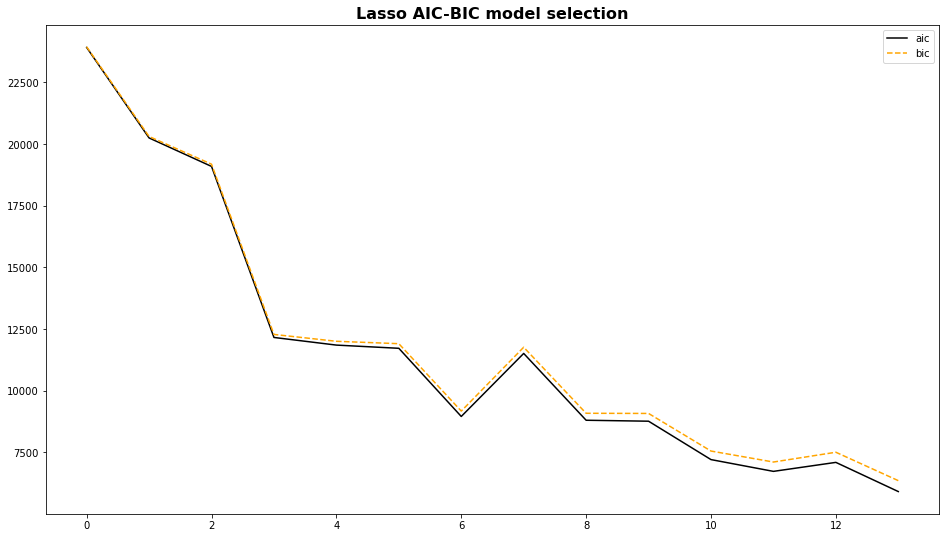

In [96]:
df_grc_rec_ord = df_grc_pur[["USER_ID", "PURCHASE_COUNT", "average_receipt"]]
df_grc_rec_ord = df_grc_rec_ord.set_index("USER_ID")

clusters_number(df_grc_rec_ord)

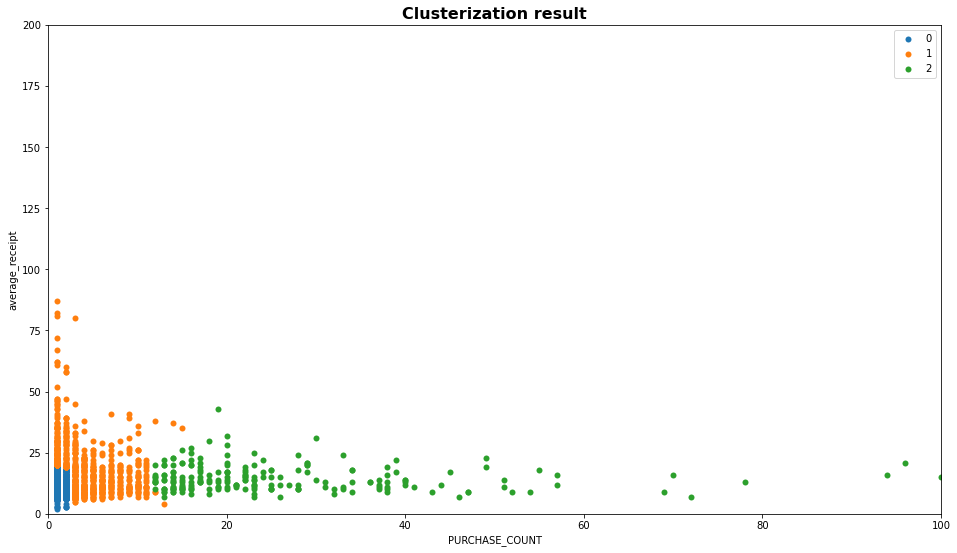

In [97]:
df_clust = clusterization(df_grc_rec_ord, 3)

In [98]:
clust_avg = df_clust.groupby("cluster").median()
clust_avg

,PURCHASE_COUNT,average_receipt
cluster,,
0,1,9
1,4,16
2,22,14


In [99]:
clust_group = df_clust.groupby("cluster").count()
clust_group

,PURCHASE_COUNT,average_receipt
cluster,,
0,631,631
1,690,690
2,211,211


In [100]:
df_beh_grc = df_clust.copy()
df_beh_grc = df_beh_grc.reset_index()
df_beh_grc = df_beh_grc[["USER_ID", "cluster"]]

df_beh_grc["behavior"] = ""
for i in range(df_beh_grc.shape[0]):
    if df_beh_grc.at[i, "cluster"] == 0:
        df_beh_grc.at[i, "store_cluster"] = "few orders, low check"
    elif df_beh_grc.at[i, "cluster"] == 1:
        df_beh_grc.at[i, "store_cluster"] = "many orders, low check"
    elif df_beh_grc.at[i, "cluster"] == 2:
        df_beh_grc.at[i, "store_cluster"] = "medium, high check"
    else:
        continue
df_beh_grc.head()

,USER_ID,cluster,behavior,store_cluster
0,21,1,,"many orders, low check"
1,34,1,,"many orders, low check"
2,43,0,,"few orders, low check"
3,51,0,,"few orders, low check"
4,55,0,,"few orders, low check"


# Output

Well, that's the final result.

In [101]:
df_final = df_cluster[["USER_ID", "country", "has_purchase", "device"]]

df_beh = pd.concat([df_beh_dnk, df_beh_fin, df_beh_grc])
df_beh = df_beh[["USER_ID", "store_cluster"]]
df_beh = df_beh.rename(columns = {"store_cluster": "behavior_cluster"})

df_dt = pd.concat([df_dt_dnk, df_dt_fin, df_dt_grc])
df_dt = df_dt[["USER_ID", "daytime_cluster"]]

df_st = pd.concat([df_st_dnk, df_st_fin, df_st_grc])
df_st = df_st[["USER_ID", "store_cluster"]]

df_final = pd.merge(df_final, df_beh, how = "left", on = "USER_ID")
df_final = pd.merge(df_final, df_dt, how = "left", on = "USER_ID")
df_final = pd.merge(df_final, df_st, how = "left", on = "USER_ID")

df_final["behavior_cluster"] = df_final["behavior_cluster"].fillna("general")
df_final["daytime_cluster"] = df_final["daytime_cluster"].fillna("general")
df_final["store_cluster"] = df_final["store_cluster"].fillna("general")

In [102]:
df_final.head()

,USER_ID,country,has_purchase,device,behavior_cluster,daytime_cluster,store_cluster
0,1,DNK,False,ios,general,general,general
1,2,FIN,True,android,"many orders, low check",,"restaurant, retail"
2,3,DNK,True,web,"many orders, small check",Dinner and Lunch,"restaurant, grocery"
3,4,FIN,False,android,general,general,general
4,5,GRC,False,android,general,general,general


In [103]:
df_final.shape[0]

21983

In [104]:
df_final.to_excel("clusterization_result.xlsx")